In [66]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import hashlib
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [39]:
df = pd.read_csv("Plant_V_Seg_all_features.csv")
df.head()

,ID_Image,Est_Saine,Image_Path,is_black,dimensions,aire,périmètre,circularité,excentricité,aspect_ratio,...,disease_Leaf_blight_(Isariopsis_Leaf_Spot),disease_Leaf_scorch,disease_Northern_Leaf_Blight,disease_Powdery_mildew,disease_Septoria_leaf_spot,disease_Spider_mites Two-spotted_spider_mite,disease_Target_Spot,disease_Tomato_Yellow_Leaf_Curl_Virus,disease_Tomato_mosaic_virus,disease_healthy
0,1,0,/workspaces/datasciencetest_reco_plante/datase...,0,27x53,549.5,224.208151,0.137365,0.908846,0.509434,...,False,False,False,False,False,False,False,False,True,False
1,2,0,/workspaces/datasciencetest_reco_plante/datase...,0,115x94,2425.0,1143.082383,0.023322,0.860274,1.223404,...,False,False,False,False,False,False,False,False,True,False
2,3,0,/workspaces/datasciencetest_reco_plante/datase...,0,73x78,1662.0,807.092487,0.032062,0.841733,0.935897,...,False,False,False,False,False,False,False,False,True,False
3,4,0,/workspaces/datasciencetest_reco_plante/datase...,0,142x170,8371.5,2032.642906,0.025462,0.710637,0.835294,...,False,False,False,False,False,False,False,False,True,False
4,5,0,/workspaces/datasciencetest_reco_plante/datase...,0,31x31,247.5,155.296463,0.128962,0.934820,1.000000,...,False,False,False,False,False,False,False,False,True,False


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54258 entries, 0 to 54257
Data columns (total 68 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ID_Image                                      54258 non-null  int64  
 1   Est_Saine                                     54258 non-null  int64  
 2   Image_Path                                    54258 non-null  object 
 3   is_black                                      54258 non-null  int64  
 4   dimensions                                    54258 non-null  object 
 5   aire                                          54258 non-null  float64
 6   périmètre                                     54258 non-null  float64
 7   circularité                                   54258 non-null  float64
 8   excentricité                                  54258 non-null  float64
 9   aspect_ratio                                  54258 non-null 

Nettoyage des données:


In [41]:
df.dtypes[df.dtypes == "object"]

Image_Path    object
dimensions    object
dtype: object

Identification des doublons dans les lignes du dataframe

In [43]:
def find_duplicate_feature_rows(df, feature_cols):
    """
    Identifie les lignes où l'ensemble des features est identique.
    Retourne un DataFrame des lignes dupliquées.
    """
    duplicates = df[df.duplicated(subset=feature_cols, keep=False)]
    return duplicates

In [ ]:
# Détection des lignes de features dupliquées
all_feature_cols = [col for col in df.columns
                    if col not in ['ID_Image','Est_Saine']]
dup_feature_rows = find_duplicate_feature_rows(df, all_feature_cols)
print(f"\nNombre de lignes de features dupliquées : {len(dup_feature_rows)}")


Nombre de lignes defeatures dupliquées : 0


In [45]:
def split_data_objectifs(df: pd.DataFrame, test_size=0.2, val_size=0.2, random_state=42):
    """
    Sépare le DataFrame en trois jeux (train/val/test) pour trois objectifs :
    1. Classification d'espèce (species)
    2. Sain vs malade (Est_Saine)
    3. Identification de la maladie (uniquement feuilles malades)

    Retourne trois dictionnaires de splits : splits_obj1, splits_obj2, splits_obj3
    """
    df_work = df.copy()

    # === Objectif 1 — Classification d'espèce ===
    # Reconstruire la colonne 'species' à partir des colonnes one-hot 'plant_*'
    plant_cols = [col for col in df_work.columns if col.startswith('plant_')]
    df_work['species'] = (
        df_work[plant_cols]
        .idxmax(axis=1)
        .str.replace('plant_', '', regex=False)
    )
    # Split train/val/test stratifié sur 'species'
    train_o1, test_o1 = train_test_split(
        df_work,
        test_size=test_size,
        stratify=df_work['species'],
        random_state=random_state
    )
    train_o1, val_o1 = train_test_split(
        train_o1,
        test_size=val_size,
        stratify=train_o1['species'],
        random_state=random_state
    )
    splits_obj1 = {'train': train_o1, 'val': val_o1, 'test': test_o1}

    # === Objectif 2 — Sain vs malade ===
    train_o2, test_o2 = train_test_split(
        df_work,
        test_size=test_size,
        stratify=df_work['Est_Saine'],
        random_state=random_state
    )
    train_o2, val_o2 = train_test_split(
        train_o2,
        test_size=val_size,
        stratify=train_o2['Est_Saine'],
        random_state=random_state
    )
    splits_obj2 = {'train': train_o2, 'val': val_o2, 'test': test_o2}

    # === Objectif 3 — Identifier la maladie (uniquement feuilles malades) ===
    # Reconstruire la colonne 'disease' à partir des colonnes one-hot 'disease_*'
    disease_cols = [col for col in df_work.columns if col.startswith('disease_')]
    df_work['disease'] = (
        df_work[disease_cols]
        .idxmax(axis=1)
        .str.replace('disease_', '', regex=False)
    )
    df_malades = df_work[df_work['Est_Saine'] == 0].copy()
    if df_malades['disease'].nunique() > 1:
        train_o3, test_o3 = train_test_split(
            df_malades,
            test_size=test_size,
            stratify=df_malades['disease'],
            random_state=random_state
        )
        train_o3, val_o3 = train_test_split(
            train_o3,
            test_size=val_size,
            stratify=train_o3['disease'],
            random_state=random_state
        )
        splits_obj3 = {'train': train_o3, 'val': val_o3, 'test': test_o3}
    else:
        splits_obj3 = {'train': None, 'val': None, 'test': None}

    # Nettoyage : suppression des colonnes temporaires
    for split in (splits_obj1, splits_obj2, splits_obj3):
        for key, subset in split.items():
            if isinstance(subset, pd.DataFrame):
                subset.drop(columns=['species', 'disease'], errors='ignore', inplace=True)

    return splits_obj1, splits_obj2, splits_obj3

# Exécution sur ton DataFrame df
splits_obj1, splits_obj2, splits_obj3 = split_data_objectifs(df)

# Vérification des tailles
print("Objectif 1 (nom_plante) :", {k: len(v) for k, v in splits_obj1.items()})
print("Objectif 2 (Est_Saine)   :", {k: len(v) for k, v in splits_obj2.items()})
print("Objectif 3 (nom_maladie) :", {k: len(v) if v is not None else 0 for k, v in splits_obj3.items()})


Objectif 1 (nom_plante) : {'train': 34724, 'val': 8682, 'test': 10852}
Objectif 2 (Est_Saine)   : {'train': 34724, 'val': 8682, 'test': 10852}
Objectif 3 (nom_maladie) : {'train': 25082, 'val': 6271, 'test': 7839}


In [46]:
# Créer un dossier pour stocker les fichiers (si pas déjà existant)
os.makedirs("splits_csv", exist_ok=True)

# Fonction d'enregistrement CSV
def save_split_to_csv(split_dict, objectif_name):
    for split_name, df_split in split_dict.items():
        if df_split is not None:
            path = f"splits_csv/{objectif_name}_{split_name}.csv"
            df_split.to_csv(path, index=False)
            print(f" Fichier enregistré : {path}")

#  Sauvegarde des 3 objectifs
save_split_to_csv(splits_obj1, "objectif1_espece")
save_split_to_csv(splits_obj2, "objectif2_sain_malade")
save_split_to_csv(splits_obj3, "objectif3_maladie")

 Fichier enregistré : splits_csv/objectif1_espece_train.csv
 Fichier enregistré : splits_csv/objectif1_espece_val.csv
 Fichier enregistré : splits_csv/objectif1_espece_test.csv
 Fichier enregistré : splits_csv/objectif2_sain_malade_train.csv
 Fichier enregistré : splits_csv/objectif2_sain_malade_val.csv
 Fichier enregistré : splits_csv/objectif2_sain_malade_test.csv
 Fichier enregistré : splits_csv/objectif3_maladie_train.csv
 Fichier enregistré : splits_csv/objectif3_maladie_val.csv
 Fichier enregistré : splits_csv/objectif3_maladie_test.csv


In [47]:
def selection_features(df_split, colonnes_features, target_column, method="rf", k=10, random_state=42):
    """
    Sélection automatique des features les plus utiles selon la cible.
    
    - df_split : DataFrame (train uniquement recommandé)
    - colonnes_features : liste des noms de colonnes de features
    - target_column : nom de la colonne cible
    - method : 'rf' pour RandomForest ou 'kbest' pour SelectKBest(f_classif)
    - k : nombre de features à retenir (pour SelectKBest)
    """

    X = df_split[colonnes_features].copy()
    y = df_split[target_column].copy()

    # Encoder y si c’est une variable catégorielle
    if y.dtype == 'object' or y.dtype.name == 'category':
        le = LabelEncoder()
        y = le.fit_transform(y)

    if method == "rf":
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X, y)
        importances = model.feature_importances_
        scores = pd.Series(importances, index=colonnes_features).sort_values(ascending=False)
    elif method == "kbest":
        selector = SelectKBest(score_func=f_classif, k=min(k, len(colonnes_features)))
        selector.fit(X, y)
        scores = pd.Series(selector.scores_, index=colonnes_features).sort_values(ascending=False)
    else:
        raise ValueError("Méthode non reconnue : choisir 'rf' ou 'kbest'")

    return scores

Objectif 1 : Classifier l’espèce (Nom_Plante)

In [48]:
# 1) Détecter automatiquement les colonnes plant_*/disease_*  
plant_cols   = [c for c in df.columns if c.startswith('plant_')]  
disease_cols = [c for c in df.columns if c.startswith('disease_')]

# 2) Colonnes à exclure des features (ID + variables cibles encodées)  
colonnes_non_features = ['ID_Image', 'nom_plante', 'nom_maladie', 'Est_Saine', 'Image_Path','dimensions'] + plant_cols + disease_cols

# 3) Liste des colonnes features  
colonnes_features = [c for c in df.columns if c not in colonnes_non_features]

# 4) Reconstruction de la cible 'species' dans le train set  
train_o1 = splits_obj1['train'].copy()  
train_o1['species'] = (
    train_o1[plant_cols]
    .idxmax(axis=1)
    .str.replace('plant_', '', regex=False)
)

# 5) Appel à la fonction de sélection de features  
scores_obj1 = selection_features(
    train_o1,
    colonnes_features,
    target_column='species',
    method='rf'
)

In [49]:
def prepare_scores_df(scores):
    """
    Prend en entrée scores (Series ou DataFrame) et renvoie un DataFrame
    à colonnes ['feature','importance'] trié par importance décroissante.
    """
    # Cas où on reçoit une pandas.Series
    if isinstance(scores, pd.Series):
        # scores.index → nom des features, scores.values → importances
        sorted_ser = scores.sort_values(ascending=False)
        df_scores = pd.DataFrame({
            'feature': sorted_ser.index,
            'importance': sorted_ser.values
        })
    # Cas où on reçoit déjà un DataFrame
    elif isinstance(scores, pd.DataFrame):
        # On suppose qu'il contient au moins les colonnes 'feature' et 'importance'
        df_scores = scores.sort_values(
            by='importance',
            ascending=False
        ).reset_index(drop=True)
    else:
        raise TypeError("scores doit être une pandas.Series ou un pandas.DataFrame")
    return df_scores

In [50]:
scores_df = prepare_scores_df(scores_obj1)
print(" Top 20 features pour l'objectif 1 :")
print(scores_df.head(20))

 Top 20 features pour l'objectif 1 :
            feature  importance
0   contour_density    0.074173
1            mean_H    0.060222
2              hu_3    0.056123
3            mean_B    0.053770
4           netteté    0.051852
5            energy    0.047576
6              hu_2    0.045857
7       homogeneity    0.045345
8            mean_R    0.044619
9            mean_S    0.042099
10      Correlation    0.041713
11    dissimilarite    0.040439
12            std_R    0.039414
13            std_G    0.035963
14         contrast    0.035172
15           mean_G    0.033742
16            std_B    0.032816
17             aire    0.031382
18           mean_V    0.030927
19             hu_1    0.026294


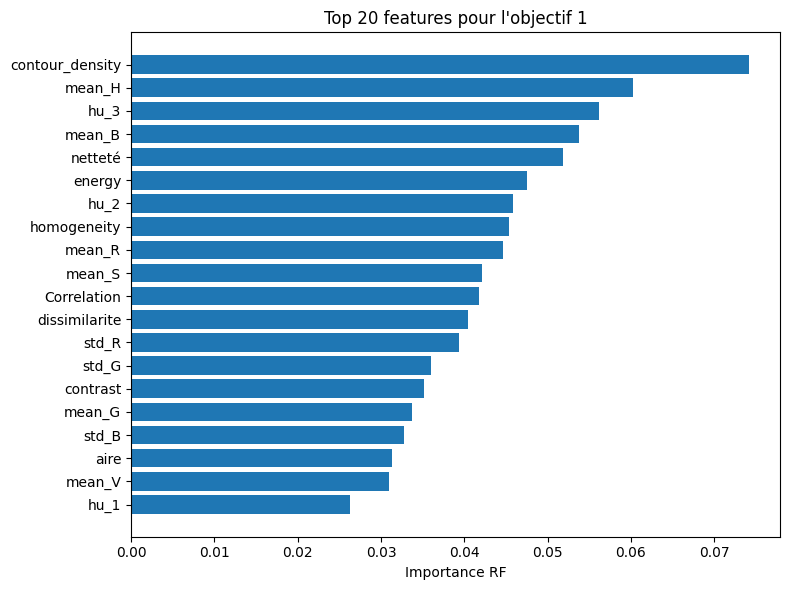

In [51]:
topk = 20
plt.figure(figsize=(8, 6))
plt.barh(
    scores_df['feature'].iloc[:topk][::-1],
    scores_df['importance'].iloc[:topk][::-1]
)
plt.xlabel("Importance RF")
plt.title(f"Top {topk} features pour l'objectif 1")
plt.tight_layout()
plt.show()

Objectif 2 : Détecter sain vs malade (Est_Saine)

In [52]:
from sklearn.feature_selection import VarianceThreshold

# 1) Préparer X et y pour l’objectif 2
train_o2 = splits_obj2['train'].copy()
X2 = train_o2[colonnes_features]
y2 = train_o2['Est_Saine']

# 2) Supprimer les colonnes à variance nulle
vt = VarianceThreshold(threshold=0.0)
vt.fit(X2)  # calcule la variance de chaque colonne
mask = vt.get_support()  
cols_non_constant = X2.columns[mask].tolist()

print(f"→ {len(X2.columns) - len(cols_non_constant)} colonnes supprimées (variance nulle)")

# 3) Mettre à jour votre liste de features
colonnes_features_obj2 = cols_non_constant

→ 1 colonnes supprimées (variance nulle)


In [55]:
from sklearn.feature_selection import SelectKBest, f_classif

# Sélectionner les k meilleures features sur le jeu nettoyé
k = 15
skb = SelectKBest(score_func=f_classif, k=k)
skb.fit(X2[colonnes_features_obj2], y2)

# Récupérer les scores
scores_obj2 = (
    pd.DataFrame({
        'feature': colonnes_features_obj2,
        'score': skb.scores_
    })
    .sort_values('score', ascending=False)
    .reset_index(drop=True)
)

print(" Top k features pour l'objectif 2 (Sain vs Malade) :")
print(scores_obj2.head(k))

 Top k features pour l'objectif 2 (Sain vs Malade) :
            feature        score
0            mean_H  3504.649196
1             std_R  3303.832066
2             std_G  1586.754268
3            mean_B  1508.344754
4             std_B  1001.852978
5            mean_S   784.025617
6              hu_3   543.247488
7       circularité   480.292661
8   contour_density   421.880188
9          contrast   397.379351
10      homogeneity   314.610210
11           energy   309.027519
12             hu_4   267.342912
13          netteté   224.354443
14     aspect_ratio   216.596235


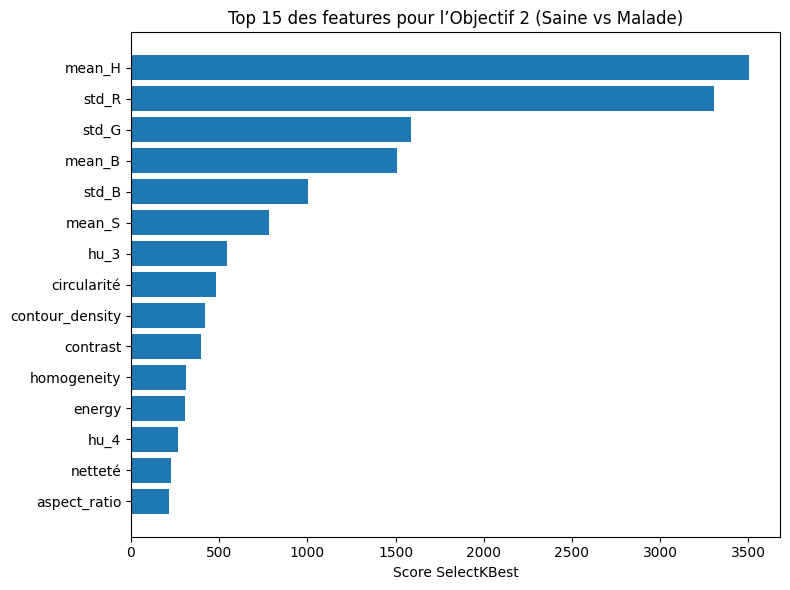

In [56]:
# 1. Préparer les données
data = {
    'feature': [
        'mean_H', 'std_R', 'std_G', 'mean_B', 'std_B',
        'mean_S', 'hu_3', 'circularité', 'contour_density',
        'contrast', 'homogeneity', 'energy', 'hu_4',
        'netteté', 'aspect_ratio'
    ],
    'score': [
        3504.649196, 3303.832066, 1586.754268, 1508.344754, 1001.852978,
        784.025617, 543.247488, 480.292661, 421.880188,
        397.379351, 314.610210, 309.027519, 267.342912,
        224.354443, 216.596235
    ]
}
df_scores = pd.DataFrame(data)

# 2. Trier pour un barh lisible (les plus hauts scores en haut)
df_scores = df_scores.sort_values(by='score', ascending=True)

# 3. Tracer le barplot horizontal
plt.figure(figsize=(8, 6))
plt.barh(df_scores['feature'], df_scores['score'])
plt.xlabel('Score SelectKBest')
plt.title('Top 15 des features pour l’Objectif 2 (Saine vs Malade)')
plt.tight_layout()
plt.show()

Objectif 3 : Identifier la maladie (Nom_Maladie)

Distribution des maladies : {'Haunglongbing_(Citrus_greening)': 3524, 'Bacterial_spot': 3466, 'Tomato_Yellow_Leaf_Curl_Virus': 3427, 'Late_blight': 1856, 'Powdery_mildew': 1847, 'Early_blight': 1278, 'Black_rot': 1150, 'Septoria_leaf_spot': 1132, 'Spider_mites Two-spotted_spider_mite': 1073, 'Target_Spot': 898, 'Esca_(Black_Measles)': 886, 'Common_rust_': 763, 'Leaf_scorch': 710, 'Leaf_blight_(Isariopsis_Leaf_Spot)': 687, 'Northern_Leaf_Blight': 630, 'Leaf_Mold': 610, 'Apple_scab': 402, 'Cercospora_leaf_spot Gray_leaf_spot': 328, 'Tomato_mosaic_virus': 239, 'Cedar_apple_rust': 176}


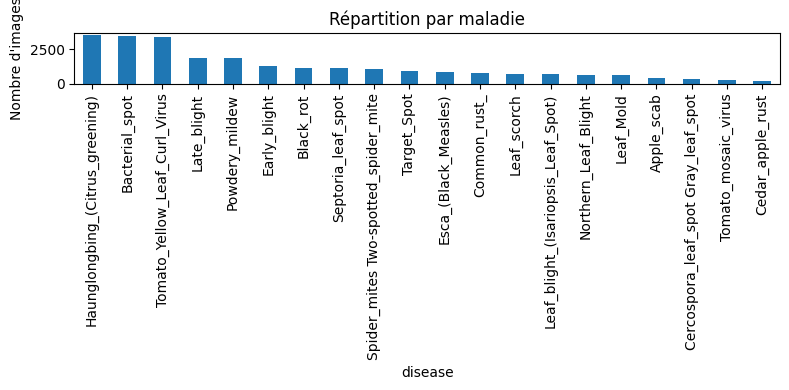

20 classes malades disponibles après imputation.
Top 15 features pour l’objectif 3 :
            feature  importance
0   contour_density    0.091277
1           netteté    0.072301
2              hu_2    0.049983
3            mean_H    0.047325
4     dissimilarite    0.046727
5            mean_R    0.042766
6            mean_B    0.042707
7       Correlation    0.042142
8             std_B    0.041823
9            mean_S    0.041691
10             hu_3    0.040267
11         contrast    0.040098
12            std_R    0.038170
13           energy    0.036742
14      homogeneity    0.036623


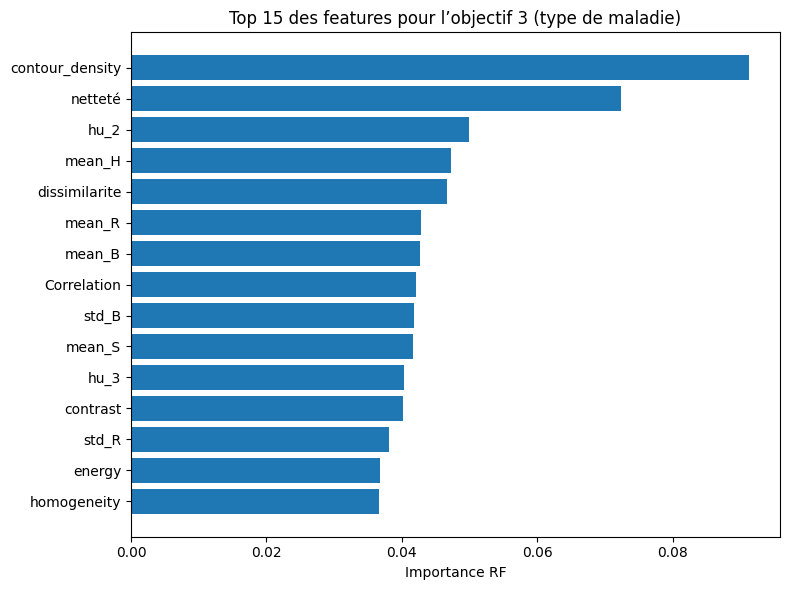

In [69]:
# 1. Récupérer le train pour Obj3
train_o3 = splits_obj3['train']
if train_o3 is None or train_o3.empty:
    print("Pas d'échantillon pour l'objectif 3.")
else:
    train_o3 = train_o3.copy()

    # 2. Refaire la cible 'disease' et garder uniquement les vraies maladies
    disease_cols = [c for c in train_o3.columns if c.startswith('disease_')]
    train_o3['disease'] = (
        train_o3[disease_cols]
        .idxmax(axis=1)
        .str.replace('disease_', '', regex=False)
    )
    train_o3 = train_o3[train_o3['disease'] != 'healthy']

    # 3. Afficher la répartition
    counts = train_o3['disease'].value_counts()
    print("Distribution des maladies :", counts.to_dict())
    plt.figure(figsize=(8,4))
    counts.plot(kind='bar')
    plt.title("Répartition par maladie")
    plt.ylabel("Nombre d'images")
    plt.tight_layout()
    plt.show()

    # 4. Préparer la liste des features
    plant_cols = [c for c in train_o3.columns if c.startswith('plant_')]
    non_feats  = ['ID_Image', 'Est_Saine', 'dimensions'] + plant_cols + disease_cols
    features   = [c for c in train_o3.columns if c not in non_feats]

    # --- 5. Identification et imputation des features numériques ---
    # On part de train_o3 déjà doté de la colonne 'disease'
    plant_cols  = [c for c in train_o3.columns if c.startswith('plant_')]
    disease_cols= [c for c in train_o3.columns if c.startswith('disease_')]
    non_feats   = ['ID_Image', 'Est_Saine', 'dimensions'] + plant_cols + disease_cols + ['Image_Path']
    # Ne garder que les colonnes numériques qui ne sont pas dans non_feats
    numeric_feats = [
        c for c in train_o3.select_dtypes(include=[np.number]).columns
        if c not in non_feats
    ]

    # Conversion forcée (au cas où)
    train_o3[numeric_feats] = train_o3[numeric_feats].apply(pd.to_numeric, errors='coerce')

    # Imputation de la médiane en place
    imputer = SimpleImputer(strategy='median')
    train_o3[numeric_feats] = imputer.fit_transform(train_o3[numeric_feats])

    # --- 6. Vérifier qu’on a bien au moins 2 classes ---
    n_classes = train_o3['disease'].nunique()
    print(f"{n_classes} classes malades disponibles après imputation.")

    # --- 7. Sélection RF ---
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(train_o3[numeric_feats], train_o3['disease'])

    importances = pd.Series(rf.feature_importances_, index=numeric_feats)
    df_scores3  = (
        importances
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={'index':'feature', 0:'importance'})
    )

    print("Top 15 features pour l’objectif 3 :")
    print(df_scores3.head(15))

    # Barplot
    top15 = df_scores3.head(15).sort_values('importance')
    plt.figure(figsize=(8,6))
    plt.barh(top15['feature'], top15['importance'])
    plt.xlabel("Importance RF")
    plt.title("Top 15 des features pour l’objectif 3 (type de maladie)")
    plt.tight_layout()
    plt.show()